출처 : https://github.com/wimlds-trojmiasto/detect-waste

출처 : https://github.com/pedropro/TACO.git

In [1]:
# detect wast
!git clone https://github.com/wimlds-trojmiasto/detect-waste.git

Cloning into 'detect-waste'...
remote: Enumerating objects: 928, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 928 (delta 71), reused 80 (delta 36), pack-reused 766
Receiving objects: 100% (928/928), 85.18 MiB | 25.87 MiB/s, done.
Resolving deltas: 100% (437/437), done.


In [2]:
!git clone https://github.com/pedropro/TACO.git

Cloning into 'TACO'...
remote: Enumerating objects: 472, done.
remote: Counting objects: 100% (202/202), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 472 (delta 147), reused 123 (delta 71), pack-reused 270
Receiving objects: 100% (472/472), 68.25 MiB | 17.68 MiB/s, done.
Resolving deltas: 100% (298/298), done.


In [3]:
!pip3 install -r /content/TACO/requirements.txt

In [4]:
# default = './data/annotations.json' 지금 코랩환경에서는 안되는 부분이기 때문에 변경
!python3 /content/TACO/download.py --dataset_path '/content/TACO/data/annotations.json'

Note. If for any reason the connection is broken. Just call me again and I will start where I left.
Finished


## EDA

In [5]:
!python3 /content/detect-waste/utils/__init__.py

Traceback (most recent call last):
  File "/content/detect-waste/utils/__init__.py", line 1, in <module>
    from utils.dataset_converter import convert_dataset, \
ModuleNotFoundError: No module named 'utils'


In [6]:
import glob

!pip install funcy
!pip install iterative-stratification==0.1.6

!python3 /content/detect-waste/MaskRCNN/utils.py

In [7]:
import sys
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


from PIL import Image, ExifTags
from pycocotools.coco import COCO
from matplotlib.patches import Polygon, Rectangle
from matplotlib.collections import PatchCollection
import colorsys
import random
import pylab

from collections import Counter

module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)



dataset_path = '/content/TACO/data'
anns_file_path = dataset_path + '/' + 'annotations.json'
# epinote_dataset_path = '/dih4/dih4_2/wimlds/data/not-annotated'
# epinote_anns_file_path = '/dih4/dih4_2/wimlds/data/annotations_epi.json'
# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())
# with open(epinote_anns_file_path, 'r') as f:
#     epinote_dataset = json.loads(f.read())

In [8]:
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 28
Number of categories: 60
Number of annotations: 4784
Number of images: 1500


In [9]:
categories

[{'id': 0, 'name': 'Aluminium foil', 'supercategory': 'Aluminium foil'},
 {'id': 1, 'name': 'Battery', 'supercategory': 'Battery'},
 {'id': 2, 'name': 'Aluminium blister pack', 'supercategory': 'Blister pack'},
 {'id': 3, 'name': 'Carded blister pack', 'supercategory': 'Blister pack'},
 {'id': 4, 'name': 'Other plastic bottle', 'supercategory': 'Bottle'},
 {'id': 5, 'name': 'Clear plastic bottle', 'supercategory': 'Bottle'},
 {'id': 6, 'name': 'Glass bottle', 'supercategory': 'Bottle'},
 {'id': 7, 'name': 'Plastic bottle cap', 'supercategory': 'Bottle cap'},
 {'id': 8, 'name': 'Metal bottle cap', 'supercategory': 'Bottle cap'},
 {'id': 9, 'name': 'Broken glass', 'supercategory': 'Broken glass'},
 {'id': 10, 'name': 'Food Can', 'supercategory': 'Can'},
 {'id': 11, 'name': 'Aerosol', 'supercategory': 'Can'},
 {'id': 12, 'name': 'Drink can', 'supercategory': 'Can'},
 {'id': 13, 'name': 'Toilet tube', 'supercategory': 'Carton'},
 {'id': 14, 'name': 'Other carton', 'supercategory': 'Carton'

## Annotations in COCO format

bbox = (x, y, width, height) area = multi_poly.area

In [10]:
anns_to_print = anns[0].pop('segmentation', None) # removing segmentation polygon for better clarity
anns[0]

{'area': 403954.0,
 'bbox': [517.0, 127.0, 447.0, 1322.0],
 'category_id': 6,
 'id': 1,
 'image_id': 0,
 'iscrowd': 0}

## 1. Dattaset statistics

### TACO categories

This shows the number of annotations per category

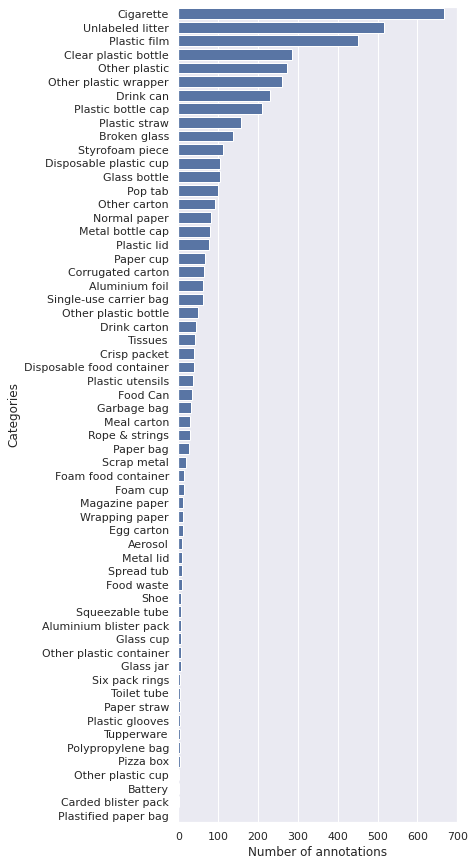

In [11]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,15))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
sns.set_color_codes("pastel")
sns.set(style="whitegrid")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df,
            label="Total", color="b")

# fig = plot_1.get_figure()
# fig.savefig("output.png")

and this shows the number of annotations per super category

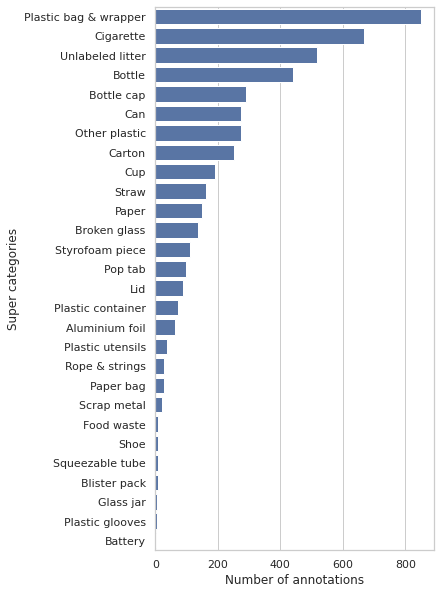

In [12]:
cat_ids_2_supercat_ids = {}
for cat in categories:
    cat_ids_2_supercat_ids[cat['id']] = super_cat_ids[cat['supercategory']]

# Count annotations
super_cat_histogram = np.zeros(nr_super_cats,dtype=int)
for ann in anns:
    cat_id = ann['category_id']
    super_cat_histogram[cat_ids_2_supercat_ids[cat_id]] +=1
    
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,10))

# Convert to DataFrame
d ={'Super categories': super_cat_names, 'Number of annotations': super_cat_histogram}
df = pd.DataFrame(d)
df = df.sort_values('Number of annotations', 0, False)

# sns.set_color_codes("pastel")
# sns.set(style="whitegrid")
plot_1 = sns.barplot(x="Number of annotations", y="Super categories", data=df,
            label="Total", color="b")
#plot_1.set_title('Annotations per super category',fontsize=20)

## detect-waste categories

This shows the number of annotations per category

In [13]:
# convert taco label to detect-waste labels
# based on polish recykling standards
# by Katrzyna łagocka


def taco_to_detectwaste(label):
    glass = ['Glass bottle','Broken glass','Glass jar']
    metals_and_plastics = ['Aluminium foil', "Clear plastic bottle","Other plastic bottle",
                         "Plastic bottle cap","Metal bottle cap","Aerosol","Drink can",
                         "Food can","Drink carton","Disposable plastic cup","Other plastic cup",
                         "Plastic lid","Metal lid","Single-use carrier bag","Polypropylene bag",
                         "Plastic Film","Six pack rings","Spread tub","Tupperware",
                         "Disposable food container","Other plastic container",
                         "Plastic glooves","Plastic utensils","Pop tab","Scrap metal",
                         "Plastic straw","Other plastic", "Plastic film", "Food Can"]
    
    non_recyclable = ["Aluminium blister pack","Carded blister pack",
                    "Meal carton","Pizza box","Cigarette","Paper cup",
                    "Meal carton","Foam cup","Glass cup","Wrapping paper",
                    "Magazine paper","Garbage bag","Plastified paper bag",
                    "Crisp packet","Other plastic wrapper","Foam food container",
                    "Rope","Shoe","Squeezable tube","Paper straw","Styrofoam piece", "Rope & strings", "Tissues"]
    
    other = ["Battery"]
    paper = ["Corrugated carton","Egg carton","Toilet tube","Other carton", "Normal paper", "Paper bag"]
    bio = ["Food waste"]
    unknown = ["Unlabeled litter"]

    if (label in glass):
            label="glass"
    elif (label in metals_and_plastics):
            label="metals_and_plastics"
    elif(label in non_recyclable):
            label="non-recyclable"
    elif(label in other):
            label="other"
    elif (label in paper):
            label="paper"
    elif(label in bio):
            label="bio"
    elif(label in unknown):
            label="unknown"
    else:
        print(label, "is non-taco label")
        label = "unknown"
    return label

In [14]:
# convert all taco anns to detect-waste anns
# let's change supercategory to detectwaste
detectwaste_categories = dataset['categories']
for ann in anns:
    cat_id = ann['category_id']
    cat_taco = categories[cat_id]['name']
    detectwaste_categories[cat_id]['supercategory'] = taco_to_detectwaste(cat_taco)
# As there is no representation of "Plastified paper bag" in annotated data, change of this supercategory was done manually.
detectwaste_categories[35]['supercategory'] = taco_to_detectwaste("Plastified paper bag")
detectwaste_categories

[{'id': 0, 'name': 'Aluminium foil', 'supercategory': 'metals_and_plastics'},
 {'id': 1, 'name': 'Battery', 'supercategory': 'other'},
 {'id': 2,
  'name': 'Aluminium blister pack',
  'supercategory': 'non-recyclable'},
 {'id': 3, 'name': 'Carded blister pack', 'supercategory': 'non-recyclable'},
 {'id': 4,
  'name': 'Other plastic bottle',
  'supercategory': 'metals_and_plastics'},
 {'id': 5,
  'name': 'Clear plastic bottle',
  'supercategory': 'metals_and_plastics'},
 {'id': 6, 'name': 'Glass bottle', 'supercategory': 'glass'},
 {'id': 7,
  'name': 'Plastic bottle cap',
  'supercategory': 'metals_and_plastics'},
 {'id': 8, 'name': 'Metal bottle cap', 'supercategory': 'metals_and_plastics'},
 {'id': 9, 'name': 'Broken glass', 'supercategory': 'glass'},
 {'id': 10, 'name': 'Food Can', 'supercategory': 'metals_and_plastics'},
 {'id': 11, 'name': 'Aerosol', 'supercategory': 'metals_and_plastics'},
 {'id': 12, 'name': 'Drink can', 'supercategory': 'metals_and_plastics'},
 {'id': 13, 'name

### 1. generate new ids for ploting histogram

In [15]:
detectwaste_ids = {}
detectwaste_cat_names = []
cat_id = 0
for cat in detectwaste_categories:
    if cat['supercategory'] not in detectwaste_ids:
        detectwaste_cat_names.append(cat['supercategory'])
        detectwaste_ids[cat['supercategory']] = cat_id
        cat_id += 1
        
print(detectwaste_ids)
print(detectwaste_cat_names)

taco_to_detectwaste_ids = {}
for i, cat in enumerate(detectwaste_categories):
#     if cat['id'] not in taco_to_detectwaste_ids:
#         taco_to_detectwaste_ids[cat['id']] = 0
    taco_to_detectwaste_ids[cat['id']] = detectwaste_ids[cat['supercategory']]
    
# print(taco_to_detectwaste_ids)

colors_recykling = ['yellow', 'gray', 'gray', 'green', 'blue', 'brown', 'pink']

anns_detectwaste = anns.copy()
for i, ann in enumerate(anns):
    #print(ann['category_id'])
    anns_detectwaste[i]['category_id'] = taco_to_detectwaste_ids[ann['category_id']]
    anns_detectwaste[i].pop('segmentation', None)

{'metals_and_plastics': 0, 'other': 1, 'non-recyclable': 2, 'glass': 3, 'paper': 4, 'bio': 5, 'unknown': 6}
['metals_and_plastics', 'other', 'non-recyclable', 'glass', 'paper', 'bio', 'unknown']


Text(0.5, 1.0, 'Annotations per detectwaste category')

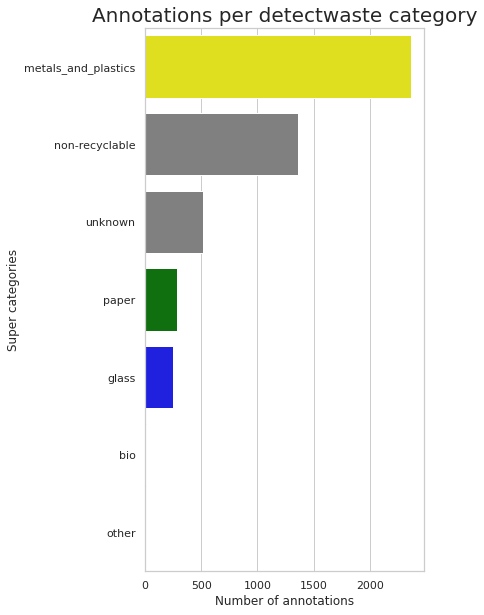

In [16]:
# Count annotations
detectwaste_cat_histogram = np.zeros(len(detectwaste_cat_names),dtype=int)

for ann in anns_detectwaste:
    cat_id = ann['category_id']
    detectwaste_cat_histogram[cat_id] +=1
    
# for ann in epi_anns:
#     cat_id = ann['category_id']
#     detectwaste_cat_histogram[cat_id] +=1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,10))

# Convert to DataFrame
d ={'Super categories': detectwaste_cat_names, 'Number of annotations': detectwaste_cat_histogram}
df = pd.DataFrame(d)
df = df.sort_values('Number of annotations', 0, False)


sns.set_palette(sns.color_palette(colors_recykling))
plot_1 = sns.barplot(x="Number of annotations", y="Super categories", data=df,
            label="Total")
plot_1.set_title('Annotations per detectwaste category',fontsize=20)

### 2. Background stats

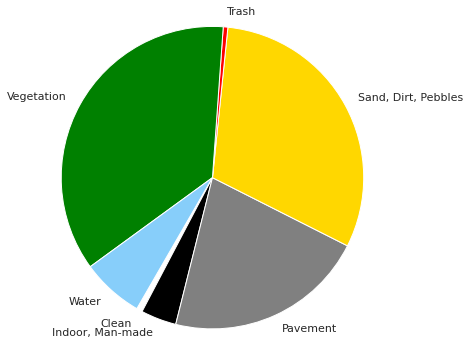

In [17]:
# Get scene cat names
scene_cats = dataset['scene_categories']
scene_name = []
pylab.rcParams['figure.figsize'] = (6,6)

for scene_cat in scene_cats:
    scene_name.append(scene_cat['name'])

nr_scenes = len(scene_cats)
scene_cat_histogram = np.zeros(nr_scenes,dtype=int)

for scene_ann in dataset['scene_annotations']:    
    scene_ann_ids = scene_ann['background_ids']
    for scene_ann_id in scene_ann_ids:
        if scene_ann_id<len(scene_cats):
            scene_cat_histogram[scene_ann_id]+=1

# Plot
colors = ['white','black','gray', 'gold', 'red','green','lightskyblue']
plt.pie(scene_cat_histogram, labels=scene_name, colors = colors,
      shadow=False, startangle=-120)
 
plt.axis('equal')
plt.show()

## 2. Visualize Annotated Images

For simplicity, to select and show the dataset images with the respective masks, we make use of the COCO API. The script below shows how to load and visualize an image with all its annotations.

Unfortunately, several python libraries do not take into account the EXIF orientation tag, thus we have to explicitly rotate the images. Alternatively you can use instead OpenCV.

The script below shows how to filter images by either category or supercategory.

Go ahead and try different (super)categories searches by changing the category_name. Note that small objects may be hard to see.

In [18]:
def extract_detectwaste_color(ann, taco_to_detectwaste_ids, colors_recykling):
    color_id = taco_to_detectwaste_ids[ann['category_id']]
    color = colors_recykling[color_id]
    return color

In [19]:
# User settings
image_filepath = 'batch_11/000028.jpg'
pylab.rcParams['figure.figsize'] = (28,28)
####################
imgs = dataset['images']

# Obtain Exif orientation tag code
for orientation in ExifTags.TAGS.keys():
    if ExifTags.TAGS[orientation] == 'Orientation':
        break

# Loads dataset as a coco object
coco = COCO(anns_file_path)

# Find image id
img_id = -1
for img in imgs:
    if img['file_name'] == image_filepath:
        img_id = img['id']
        break

# Show image and corresponding annotations
if img_id == -1:
    print('Incorrect file name')
else:

    # Load image
    print(image_filepath)
    I = Image.open(dataset_path + '/' + image_filepath)

    # Load and process image metadata
    if I._getexif():
        exif = dict(I._getexif().items())
        # Rotate portrait and upside down images if necessary
        if orientation in exif:
            if exif[orientation] == 3:
                I = I.rotate(180,expand=True)
            if exif[orientation] == 6:
                I = I.rotate(270,expand=True)
            if exif[orientation] == 8:
                I = I.rotate(90,expand=True)

    # Show image
    fig,ax = plt.subplots(1)
    plt.axis('off')
    plt.imshow(I)

    # Load mask ids
    annIds = coco.getAnnIds(imgIds=img_id, catIds=[], iscrowd=None)
    anns_sel = coco.loadAnns(annIds)

    # Show annotations 
    for ann in anns_sel:
        color = extract_detectwaste_color(ann, taco_to_detectwaste_ids, colors_recykling)
        for seg in ann['segmentation']:
            poly = Polygon(np.array(seg).reshape((int(len(seg)/2), 2)))
            p = PatchCollection([poly], facecolor=color, edgecolors=color,linewidths=0, alpha=0.4)
            ax.add_collection(p)
            p = PatchCollection([poly], facecolor='none', edgecolors=color, linewidths=2)
            ax.add_collection(p)
        [x, y, w, h] = ann['bbox']
        rect = Rectangle((x,y),w,h,linewidth=2,edgecolor=color,
                         facecolor='none', alpha=0.7, linestyle = '--')
        ax.add_patch(rect)

    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [20]:
categories_to_show = ['Bottle', 'Shoe', 'Food waste']
nr_img_2_display = 1
pylab.rcParams['figure.figsize'] = (14,14)

for category_name in categories_to_show: #  --- Insert the name of one of the categories or super-categories above

    # Obtain Exif orientation tag code
    for orientation in ExifTags.TAGS.keys():
        if ExifTags.TAGS[orientation] == 'Orientation':
            break

    # Loads dataset as a coco object
    coco = COCO(anns_file_path)

    # Get image ids
    imgIds = []
    catIds = coco.getCatIds(catNms=[category_name])
    if catIds:
        # Get all images containing an instance of the chosen category
        imgIds = coco.getImgIds(catIds=catIds)
    else:
        # Get all images containing an instance of the chosen super category
        catIds = coco.getCatIds(supNms=[category_name])
        for catId in catIds:
            imgIds += (coco.getImgIds(catIds=catId))
        imgIds = list(set(imgIds))

    nr_images_found = len(imgIds) 
    print('Number of images found: ',nr_images_found)

    # Select N random images
    random.shuffle(imgIds)
    imgs = coco.loadImgs(imgIds[0:min(nr_img_2_display,nr_images_found)])

    for img in imgs:
        image_path = dataset_path + '/' + img['file_name']
        # Load image
        I = Image.open(image_path)

        # Load and process image metadata
        if I._getexif():
            exif = dict(I._getexif().items())
            # Rotate portrait and upside down images if necessary
            if orientation in exif:
                if exif[orientation] == 3:
                    I = I.rotate(180,expand=True)
                if exif[orientation] == 6:
                    I = I.rotate(270,expand=True)
                if exif[orientation] == 8:
                    I = I.rotate(90,expand=True)

        # Show image
        fig,ax = plt.subplots(1)
        plt.axis('off')
        plt.imshow(I)

        # Load mask ids
        annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
        anns_sel = coco.loadAnns(annIds)

        # Show annotations
        for ann in anns_sel:
            color = extract_detectwaste_color(ann, taco_to_detectwaste_ids, colors_recykling)
            for seg in ann['segmentation']:
                poly = Polygon(np.array(seg).reshape((int(len(seg)/2), 2)))
                p = PatchCollection([poly], facecolor=color, edgecolors=color,linewidths=0, alpha=0.4)
                ax.add_collection(p)
                p = PatchCollection([poly], facecolor='none', edgecolors=color, linewidths=2)
                ax.add_collection(p)
            [x, y, w, h] = ann['bbox']
            rect = Rectangle((x,y),w,h,linewidth=2,edgecolor=color,
                             facecolor='none', alpha=0.7, linestyle = '--')
            ax.add_patch(rect)

        plt.show()

Output hidden; open in https://colab.research.google.com to view.

## 3. bbox statistic

- average bbox size per category
- average area size per category
- average number of bbox per image

In [21]:
anns_detectwaste[1]

{'area': 1071259.5,
 'bbox': [1.0, 457.0, 1429.0, 1519.0],
 'category_id': 2,
 'id': 2,
 'image_id': 1,
 'iscrowd': 0}

In [22]:
def bbox_stats(anns, calc = 'mean', verbose = 1):
    picsw = [pic['bbox'][2] for pic in anns]
    picsh = [pic['bbox'][3] for pic in anns]
    bbox_size = [w * h for w, h, in zip(picsw,picsh)]
    if calc == 'mean':
        return np.mean(bbox_size)
    if calc == 'median':
        return np.median(bbox_size)

def area_stats(anns, calc = 'mean', verbose = 1):
    picsw = [pic['area'] for pic in anns]
    picsh = [pic['area'] for pic in anns]
    area_size = [w * h for w, h, in zip(picsw,picsh)]
    if calc == 'mean':
        return np.mean(area_size)
    if calc == 'median':
        return np.median(area_size)

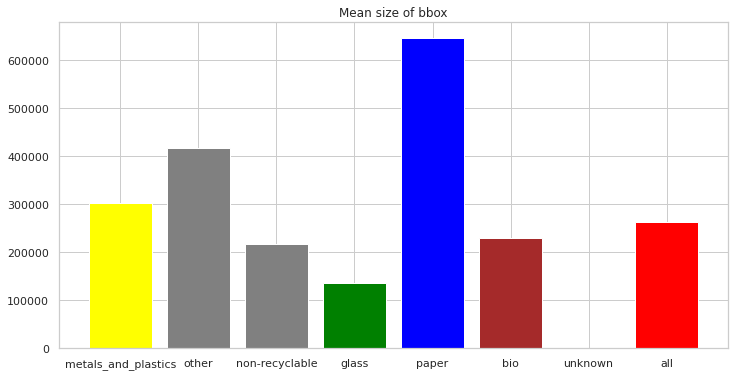

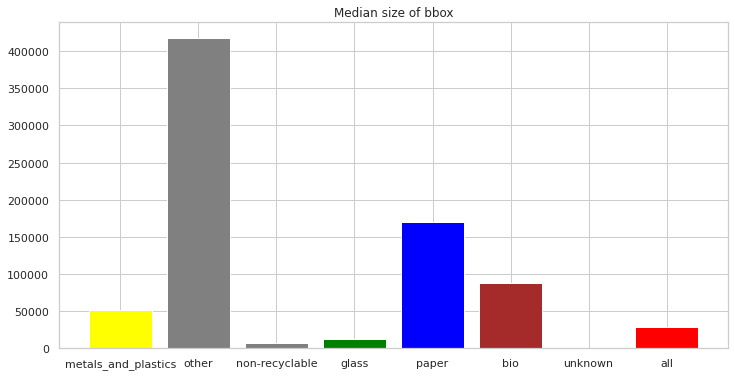

In [23]:
pylab.rcParams['figure.figsize'] = (12,6)

mean_bbox = []
median_bbox = []
for cat_nr, cat in enumerate(detectwaste_cat_names):
    temp_anns = [ann for ann in anns_detectwaste if(ann['category_id'] == cat_nr)]
    mean_bbox.append(bbox_stats(temp_anns,)) 
    median_bbox.append(bbox_stats(temp_anns,'median'))
mean_bbox[-1] =0
median_bbox[-1] =0

# append stats for all for comparison
temp_detectwaste_cat_names = detectwaste_cat_names.copy()
temp_detectwaste_cat_names.append('all')
mean_bbox.append(bbox_stats(anns_detectwaste)) 
median_bbox.append(bbox_stats(anns_detectwaste,'median'))

colors = []
colors = colors_recykling.copy()
colors.append('red')
plt.bar(temp_detectwaste_cat_names,mean_bbox, color=colors)
plt.title('Mean size of bbox')
plt.show()

plt.bar(temp_detectwaste_cat_names,median_bbox, color=colors)
plt.title('Median size of bbox')
plt.show()

['metals_and_plastics', 'other', 'non-recyclable', 'glass', 'paper', 'bio', 'unknown', 'all']


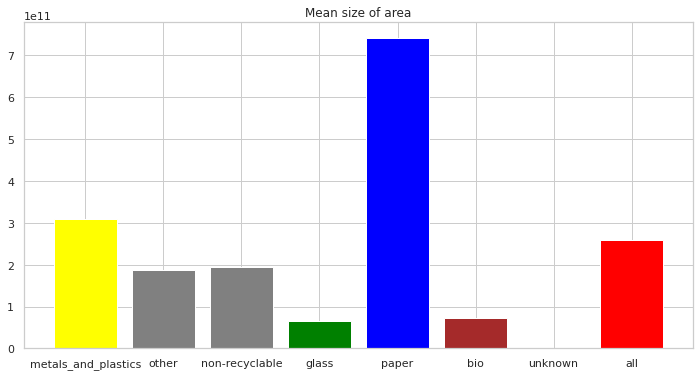

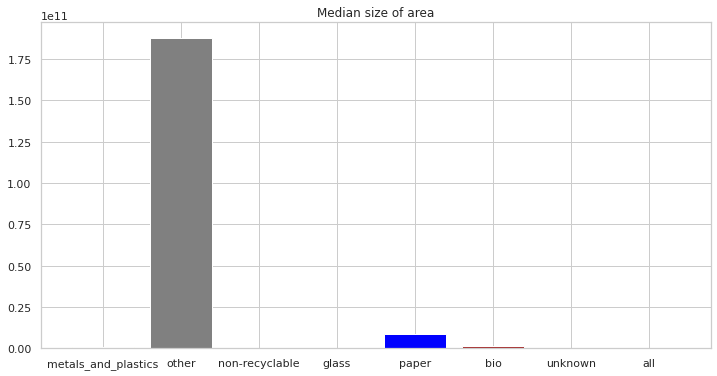

In [24]:
mean_area = []
median_area = []
for cat_nr, cat in enumerate(detectwaste_cat_names):
    temp_anns = [ann for ann in anns_detectwaste if(ann['category_id'] == cat_nr)]
    mean_area.append(area_stats(temp_anns,)) 
    median_area.append(area_stats(temp_anns,'median'))

mean_area[-1] = 0
median_area[-1] = 0
mean_area.append(area_stats(anns_detectwaste)) 
median_area.append(area_stats(anns_detectwaste,'median'))
print(temp_detectwaste_cat_names)

plt.bar(temp_detectwaste_cat_names,mean_area, color=colors)
plt.title('Mean size of area')
plt.show()

plt.bar(temp_detectwaste_cat_names,median_area, color=colors)
plt.title('Median size of area')
plt.show()

## Number of bboxes per image

In [25]:
def no_bbox_per_image(anns):
    temo_im_ids = ([ann['image_id'] for ann in anns])
    temp_im_ids = Counter(temo_im_ids)
    list_of_duplicates = [temp_im_ids[i] for i,im_id in enumerate(temp_im_ids)]
    list_of_duplicates = list(filter(lambda duplicate: duplicate != 0, list_of_duplicates))
    return np.mean(list_of_duplicates)
def no_bbox_summary(anns):
    temo_im_ids = ([ann['image_id'] for ann in anns])
    temp_im_ids = Counter(temo_im_ids)
    list_of_duplicates = [temp_im_ids[i] for i,im_id in enumerate(temp_im_ids)]
    list_of_duplicates = list(filter(lambda duplicate: duplicate != 0, list_of_duplicates))
    print('Maximum bboxes: ',np.max(list_of_duplicates))
    print('Mean number of bboxes: ',np.mean(list_of_duplicates))
    print('Median number of bboxes: ',np.median(list_of_duplicates))


print('all:',no_bbox_per_image(anns_detectwaste))
for cat_nr, cat in enumerate(detectwaste_cat_names):
    try:
        temp_anns = [ann for ann in anns_detectwaste if(ann['category_id'] == cat_nr)]
        print('\n', cat)
        no_bbox_summary(temp_anns)
    except:
        continue

all: 3.1893333333333334

 metals_and_plastics
Maximum bboxes:  33
Mean number of bboxes:  2.0803782505910164
Median number of bboxes:  1.0

 other

 non-recyclable
Maximum bboxes:  25
Mean number of bboxes:  2.1226765799256504
Median number of bboxes:  1.0

 glass
Maximum bboxes:  2
Mean number of bboxes:  1.1
Median number of bboxes:  1.0

 paper
Maximum bboxes:  5
Mean number of bboxes:  1.5128205128205128
Median number of bboxes:  1.0

 bio

 unknown
Maximum bboxes:  9
Mean number of bboxes:  2.0638297872340425
Median number of bboxes:  1.0


## Number of images per image shape

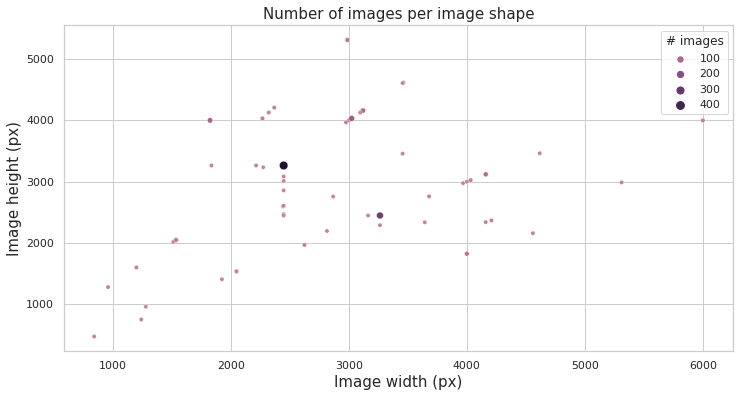

In [26]:
# Parsing image shapes (resolutions)
widths = []
heights = []
shape_freqs = []
img_shapes_keys = {}
for img in dataset['images']:
    key = str(img['width'])+'-'+str(img['height'])
    if key in img_shapes_keys:
        shape_id = img_shapes_keys[key]
        shape_freqs[shape_id] += 1
    else:
        img_shapes_keys[key] = len(widths)
        widths.append(img['width'])
        heights.append(img['height'])
        shape_freqs.append(1)
# for img in epinote_dataset['images']:
#     key = str(img['width'])+'-'+str(img['height'])
#     if key in img_shapes_keys:
#         shape_id = img_shapes_keys[key]
#         shape_freqs[shape_id] += 1
#     else:
#         img_shapes_keys[key] = len(widths)
#         widths.append(img['width'])
#         heights.append(img['height'])
#         shape_freqs.append(1)

d ={'Image width (px)': widths, 'Image height (px)': heights, '# images': shape_freqs}
df = pd.DataFrame(d)
cmap = sns.cubehelix_palette(dark=.1, light=.6, as_cmap=True)
plot = sns.scatterplot(x="Image width (px)", y="Image height (px)", size='# images', hue="# images", palette = cmap,data=df)
plt.xlabel('Image width (px)', fontsize=15)
plt.ylabel('Image height (px)', fontsize=15)
plot = plot.set_title('Number of images per image shape',fontsize=15)

## Placement of central point of the bbox in the image

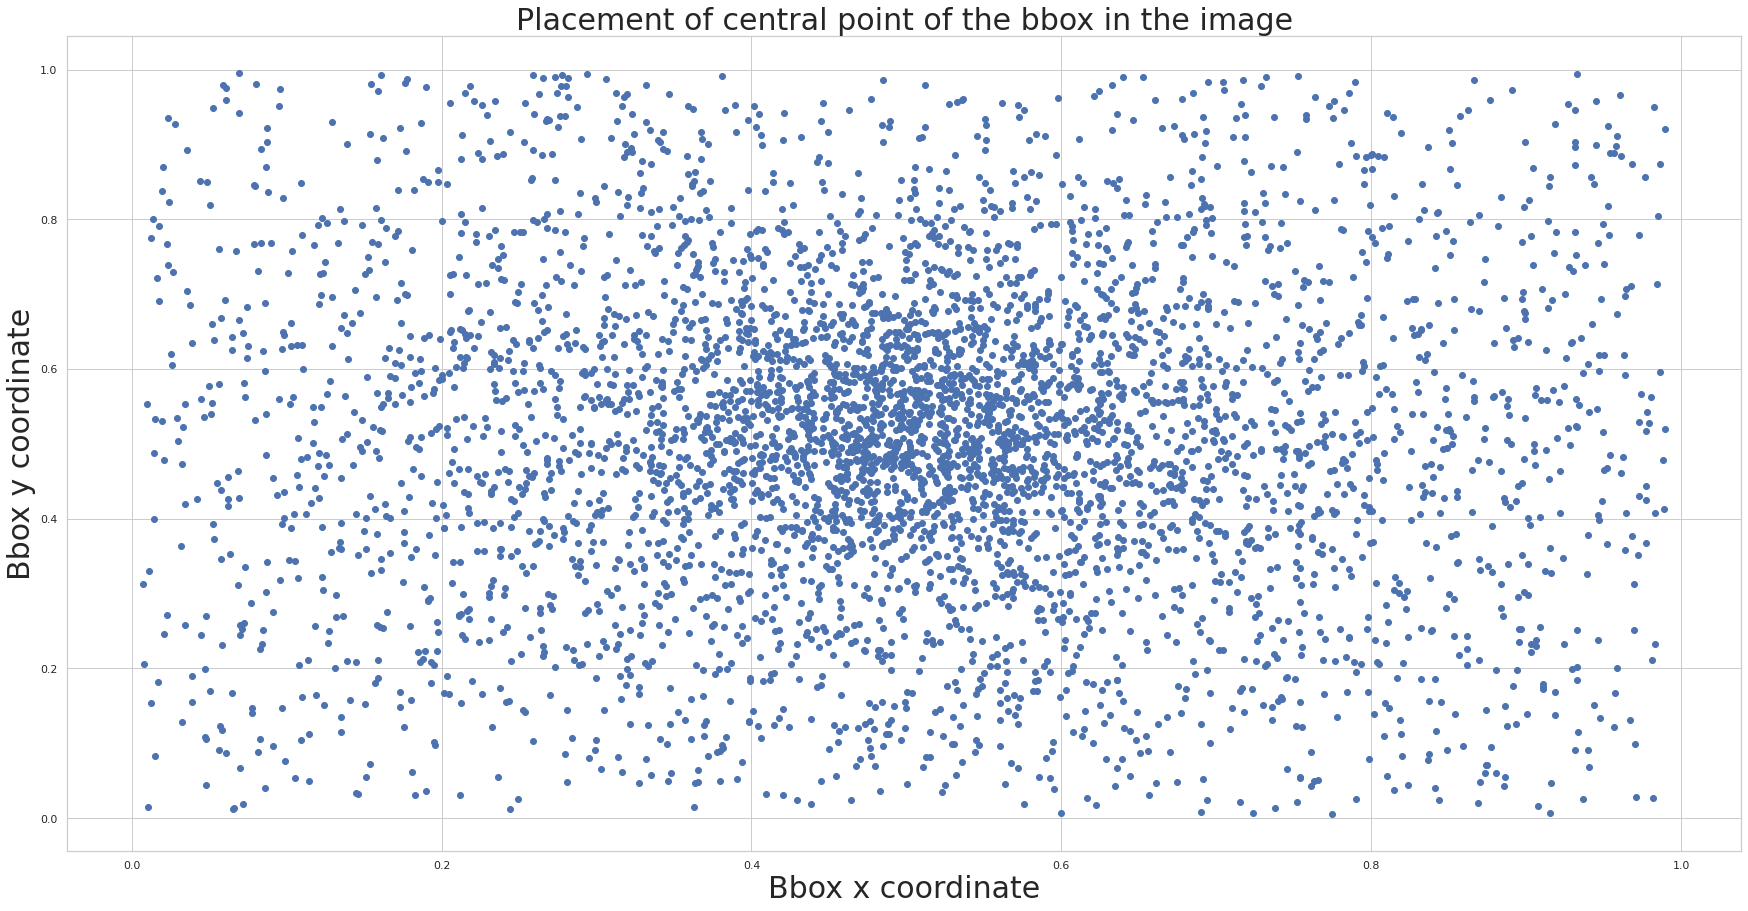

In [27]:
center_x = []
center_y = []
for i in range(0, len(anns_detectwaste)):
    for j in range (0, len(dataset['images'])):
        if dataset['images'][j]['id'] == anns_detectwaste[i]['image_id']:
            
            center_x.append((anns_detectwaste[i]['bbox'][0]+anns_detectwaste[i]['bbox'][2]/2)/dataset['images'][j]['width'])
            center_y.append((anns_detectwaste[i]['bbox'][1]+anns_detectwaste[i]['bbox'][3]/2)/dataset['images'][j]['height'])
# for i in range(0, len(epi_anns)):
#     for j in range (0, len(epinote_dataset['images'])):
#         if epinote_dataset['images'][j]['id'] == epi_anns[i]['image_id']:
            
#             center_x.append((epi_anns[i]['bbox'][0]+epi_anns[i]['bbox'][2]/2)/epinote_dataset['images'][j]['width'])
#             center_y.append((epi_anns[i]['bbox'][1]+epi_anns[i]['bbox'][3]/2)/epinote_dataset['images'][j]['height'])
plt.figure(figsize=(30,15))
plt.plot(center_x, center_y, 'bo')
plt.title('Placement of central point of the bbox in the image', fontsize=30)
plt.xlabel('Bbox x coordinate', fontsize=30)
plt.ylabel('Bbox y coordinate', fontsize=30)
plt.show()

## Number of annotations per image

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Mean number of annotations per image: 3.1893333333333334


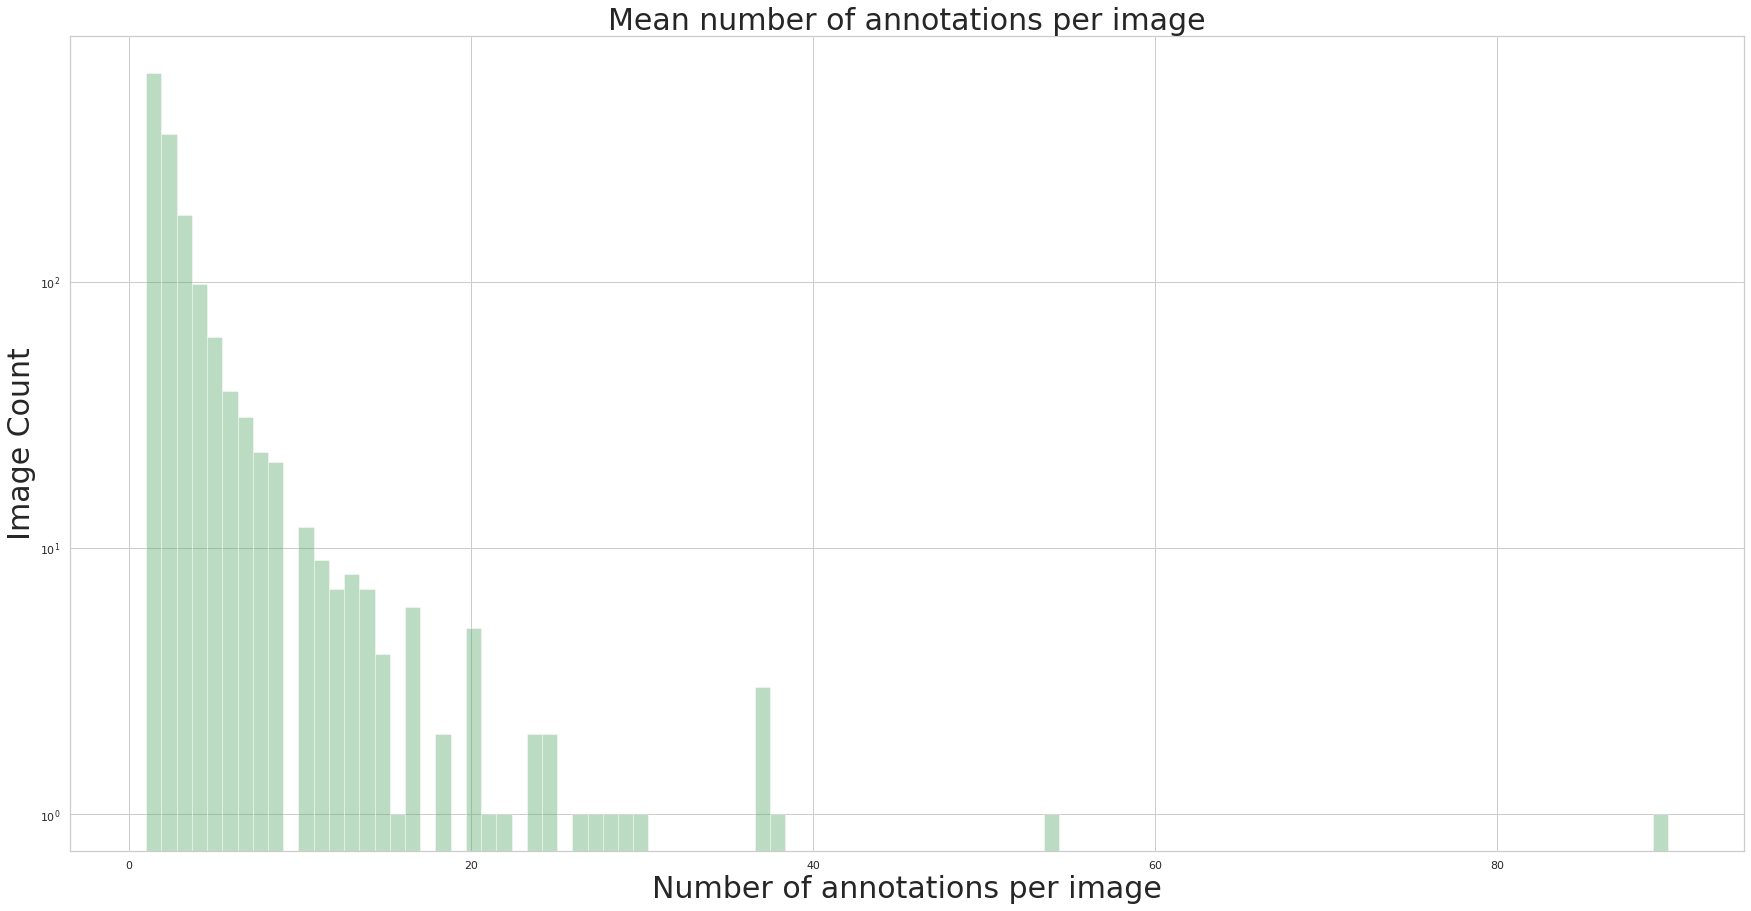

In [28]:
nr_annotation_per_image = []
annotations_per_image = []
for img in dataset['images']:
    annotations_per_image = []
    for i in range(0, len(anns_detectwaste)):
        if img['id'] == anns_detectwaste[i]['image_id']:
            annotations_per_image.append(anns_detectwaste[i]['id'])
    nr_annotation_per_image.append(len(annotations_per_image))
# for img in epinote_dataset['images']:
#     annotations_per_image = []
#     for i in range(0, len(epi_anns)):
#         if img['id'] == epi_anns[i]['image_id']:
#             annotations_per_image.append(epi_anns[i]['id'])
#     nr_annotation_per_image.append(len(annotations_per_image)) 
plt.figure(figsize=(30,15))
ax = sns.distplot(nr_annotation_per_image,kde=False,bins=100, color='g')
ax.set_yscale('log')
plt.title('Mean number of annotations per image', fontsize=30)
plt.xlabel('Number of annotations per image', fontsize=30)
plt.ylabel('Image Count', fontsize=30)

print('Mean number of annotations per image:',np.mean(nr_annotation_per_image))

## Bbox size - absolute and relative

According to MS COCO Evaluation. This dataset has:
1181 small objects (area<32*32 px)
2011 medium objects (area<96*96 px)
2561 large objects (area>96*96 px)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Number of bboxes smaller than 1024: 4712
Number of bboxes larger than 1024: 72
Number of missing annotations 363


Text(0.5, 1.0, 'Bounding-boxes size')

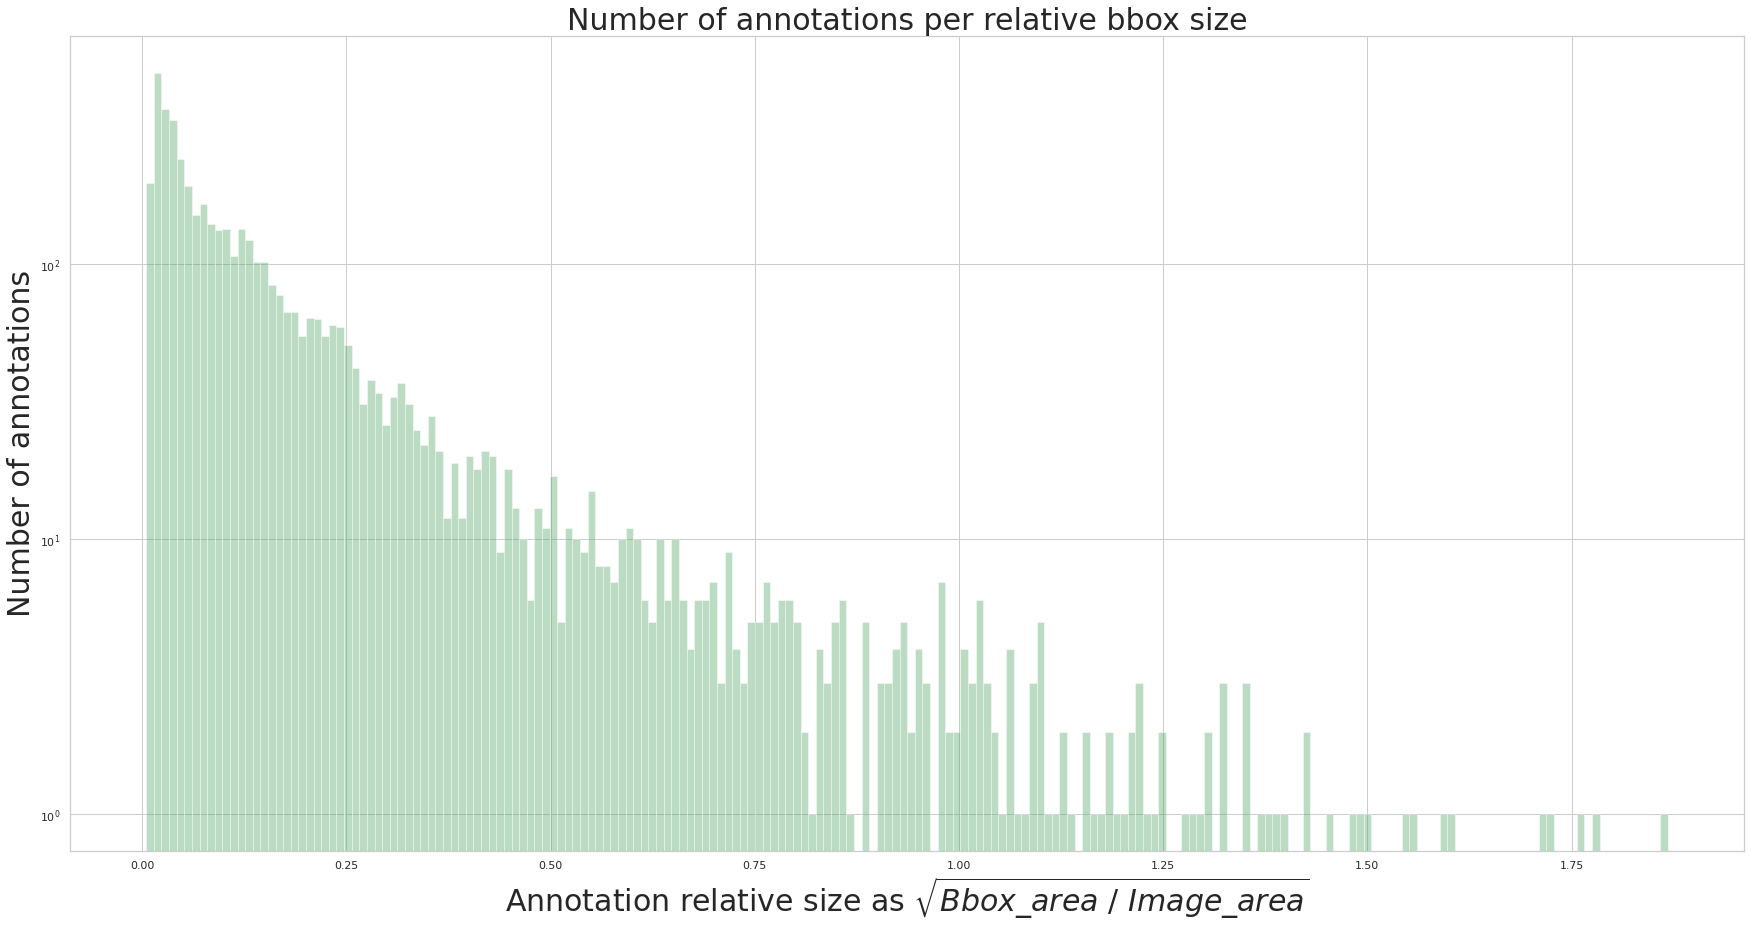

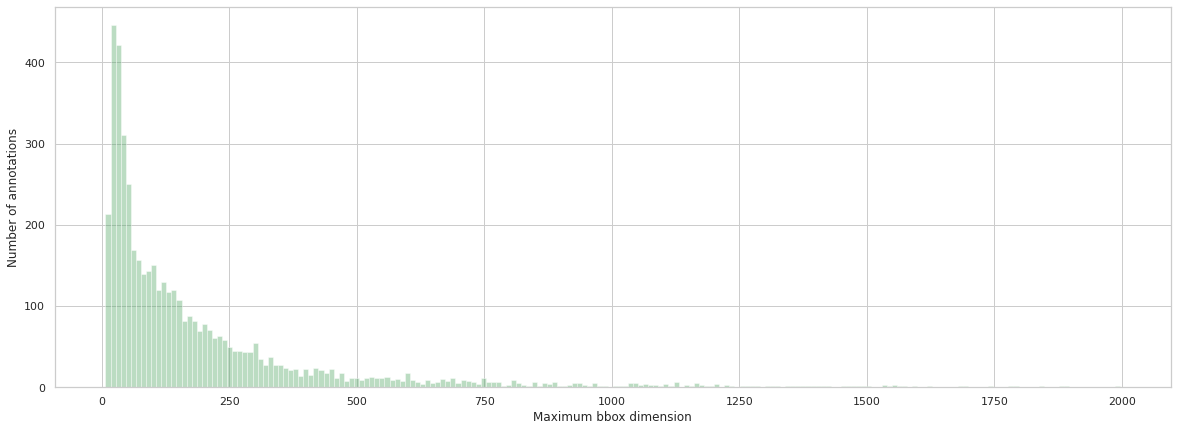

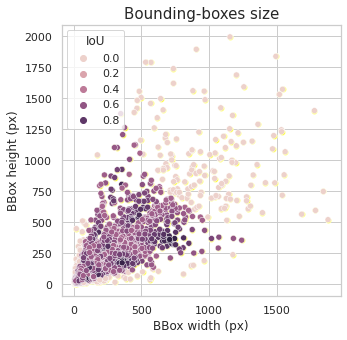

In [29]:
bbox_widths = []
bbox_heights = []
obj_areas_sqrt = []
obj_areas_sqrt_fraction = []
bbox_aspect_ratio = []
max_image_dim = 1024

for ann in anns_detectwaste:
    
    imgs = dataset['images']
    
    resize_scale = max_image_dim/max(imgs[0]['width'], imgs[0]['height'])
    # Uncomment this to work on original image size
#     resize_scale = 1
    
    bbox_widths.append(ann['bbox'][2]*resize_scale)
    bbox_heights.append(ann['bbox'][3]*resize_scale)
    obj_area = ann['bbox'][2]*ann['bbox'][3]*resize_scale**2 # ann['area']
    obj_areas_sqrt.append(np.sqrt(obj_area))
        
    img_area = imgs[0]['width']*imgs[0]['height']*resize_scale**2
    obj_areas_sqrt_fraction.append(np.sqrt(obj_area/img_area))
    
# for ann in epi_anns:
    
#     imgs = dataset['images']
    
#     resize_scale = max_image_dim/max(imgs[0]['width'], imgs[0]['height'])
#     # Uncomment this to work on original image size
# #     resize_scale = 1
    
#     bbox_widths.append(ann['bbox'][2]*resize_scale)
#     bbox_heights.append(ann['bbox'][3]*resize_scale)
#     obj_area = ann['bbox'][2]*ann['bbox'][3]*resize_scale**2 # ann['area']
#     obj_areas_sqrt.append(np.sqrt(obj_area))
        
#     img_area = imgs[0]['width']*imgs[0]['height']*resize_scale**2
#     obj_areas_sqrt_fraction.append(np.sqrt(obj_area/img_area))
    
print('According to MS COCO Evaluation. This dataset has:')
print(np.sum(np.array(obj_areas_sqrt)<32), 'small objects (area<32*32 px)')
print(np.sum(np.array(obj_areas_sqrt)<64), 'medium objects (area<96*96 px)')
print(np.sum(np.array(obj_areas_sqrt)<96), 'large objects (area>96*96 px)')
    
# d ={'Bbox width (px)': bbox_widths, 'Bbox height (px)': bbox_heights, 'area': seg_areas}
# df = pd.DataFrame(d)

plt.figure(figsize=(30,15))
ax = sns.distplot(obj_areas_sqrt_fraction,kde=False, bins=200, color='g')
ax.set_yscale('log')
plt.title('Number of annotations per relative bbox size', fontsize=30)
plt.xlabel(r'Annotation relative size as $\sqrt{ Bbox\_area \ /  \ Image\_area}$', fontsize=30)
plt.ylabel('Number of annotations', fontsize=30)

plt.figure(figsize=(20,7))
ax = sns.distplot(np.maximum(np.array(bbox_widths),np.array(bbox_heights)),kde=False, bins=200, color='g')
ax = ax.set(xlabel='Maximum bbox dimension', ylabel='Number of annotations')

import colorsys
fig, ax = plt.subplots(1, 1, figsize=(5,5))

# Plotting bbox dims
d ={'BBox width (px)': bbox_widths, 'BBox height (px)': bbox_heights}
df = pd.DataFrame(d)
cmap = sns.cubehelix_palette(dark=.1, light=.6, as_cmap=True)
ax = sns.scatterplot(x="BBox width (px)", y="BBox height (px)", palette = cmap,data=df)

print('Number of bboxes smaller than 1024:',np.sum(np.array(bbox_widths)<1024))
print('Number of bboxes larger than 1024:',np.sum(np.array(bbox_widths)>1024))

# anchors = [(32,32),(64,64),(128,128),(256,256),(512,512)]
scales, ratios = np.meshgrid(np.array([16,32,64,128,256,512]), np.array([0.5,1,2]))
scales = scales.flatten()
ratios = ratios.flatten()
# Enumerate heights and widths from scales and ratios
anchor_heights = scales / np.sqrt(ratios)
anchor_widths = scales * np.sqrt(ratios)

IoUs = []
for i in range(len(bbox_widths)):
    bbox_area = bbox_widths[i]*bbox_heights[i]
    IoU_max = 0.0
    for j in range(len(anchor_heights)):
        anchor_area = anchor_heights[j]*anchor_widths[j]
        intersection_area = min(anchor_widths[j],bbox_widths[i])*min(anchor_heights[j], bbox_heights[i])
        IoU = intersection_area / (bbox_area + anchor_area - intersection_area)
        if IoU>0.5:
            IoU_max = IoU
    IoUs.append(IoU_max)
    
print('Number of missing annotations', np.sum(np.array(IoUs)==0.0))
  
# Plotting bbox dims
d ={'BBox width (px)': bbox_widths, 'BBox height (px)': bbox_heights, 'IoU': IoUs}
df = pd.DataFrame(d)
cmap = sns.cubehelix_palette(dark=.1, light=.6, as_cmap=True)
ax = sns.scatterplot(x="BBox width (px)", y="BBox height (px)", hue = 'IoU',data=df)
plt.title('Bounding-boxes size', fontsize=15)

# 모델링

In [30]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
from shutil import copyfile
import os
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [31]:
annFile='/content/TACO/data/annotations.json' # path to example annotations
dataDir = '/content/TACO/data' # path to your directory with images - TO CHANGE

In [32]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [33]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(', '.join(nms)))

COCO categories: 
Aluminium foil, Battery, Aluminium blister pack, Carded blister pack, Other plastic bottle, Clear plastic bottle, Glass bottle, Plastic bottle cap, Metal bottle cap, Broken glass, Food Can, Aerosol, Drink can, Toilet tube, Other carton, Egg carton, Drink carton, Corrugated carton, Meal carton, Pizza box, Paper cup, Disposable plastic cup, Foam cup, Glass cup, Other plastic cup, Food waste, Glass jar, Plastic lid, Metal lid, Other plastic, Magazine paper, Tissues, Wrapping paper, Normal paper, Paper bag, Plastified paper bag, Plastic film, Six pack rings, Garbage bag, Other plastic wrapper, Single-use carrier bag, Polypropylene bag, Crisp packet, Spread tub, Tupperware, Disposable food container, Foam food container, Other plastic container, Plastic glooves, Plastic utensils, Pop tab, Rope & strings, Scrap metal, Shoe, Squeezable tube, Plastic straw, Paper straw, Styrofoam piece, Unlabeled litter, Cigarette



Image n°672
Image name: /content/TACO/data/batch_15/000071.jpg


(-0.5, 2447.5, 3263.5, -0.5)

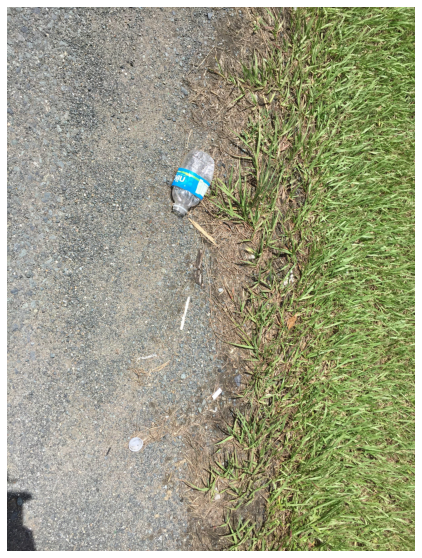

In [34]:
# load and display image
catIds = coco.getCatIds(catNms=['non recyclable'])
imgIds = coco.getImgIds(catIds=catIds)
img_id = imgIds[np.random.randint(0,len(imgIds))]
print('Image n°{}'.format(img_id))

img = coco.loadImgs(img_id)[0]

img_name = '%s/%s'%(dataDir, img['file_name'])
print('Image name: {}'.format(img_name))

I = io.imread(img_name)
plt.figure()
plt.imshow(I)
plt.axis('off')

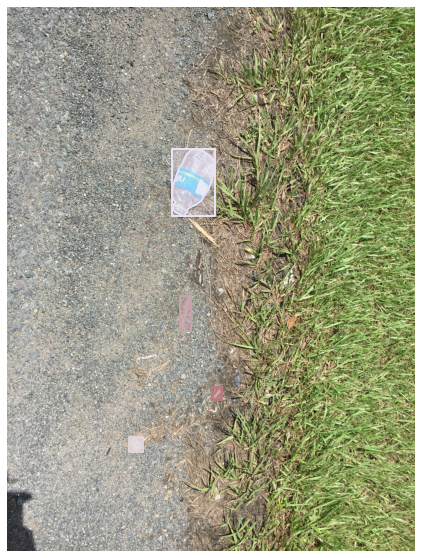

In [35]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True)

In [36]:
!python /content/detect-waste/MaskRCNN/train.py
!python 

Traceback (most recent call last):
  File "/content/detect-waste/MaskRCNN/train.py", line 15, in <module>
    from efficientnet_pytorch import EfficientNet
ModuleNotFoundError: No module named 'efficientnet_pytorch'
Python 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0] on linux
Type "help", "copyright", "credits" or "license" for more information.
>>> 'help'
'help'
>>> 
>>> 
>>> 
>>> 
>>> 
>>> 
>>> 
>>> 
>>> 

KeyboardInterrupt
>>> ^C


In [37]:
# 데이터 불러오기
from glob import glob
from keras.preprocessing import image
from tqdm import tqdm

PATH = '/content/drive/MyDrive/인공지능 그랜드 챌린지/dataset_4차_트랙3_sample'

os.chdir(PATH)
img_list = glob('*.JPG')

img_list = sorted(img_list)
images = []
for i in tqdm(img_list):
  img = image.load_img(i)

  img = np.array(img)

  images.append(img)

images = np.array(images)

100%|██████████| 30/30 [00:30<00:00,  1.03s/it]


In [38]:
import os
import torch
from PIL import Image
import numpy as np
import torchvision.transforms as T
from matplotlib import pyplot as plt
sys.path.append('../')

In [39]:
!python3 train.py --num_epochs 26 --gpu_id 2 --output_dir /content/checkpoints --images_dir /content/batch_1/

python3: can't open file 'train.py': [Errno 2] No such file or directory


In [40]:
!pip install neptune-client

     |████████████████████████████████| 278 kB 13.0 MB/s 
     |████████████████████████████████| 829 kB 79.2 MB/s 
     |████████████████████████████████| 52 kB 2.0 MB/s 
     |████████████████████████████████| 180 kB 94.4 MB/s 
     |████████████████████████████████| 131 kB 83.3 MB/s 
     |████████████████████████████████| 8.1 MB 83.0 MB/s 
     |████████████████████████████████| 79 kB 7.8 MB/s 
     |████████████████████████████████| 138 kB 91.6 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
     |████████████████████████████████| 127 kB 99.2 MB/s 
     |████████████████████████████████| 129 kB 93.7 MB/s 
     |████████████████████████████████| 67 kB 7.3 MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.13.1-py2.py3-none-any.whl size=482645 sha256=481dac4a0936224641fbff5522f35c49b6371e509514d472b520ca3fccbd8c03
  Stored in directory: /root/.cache/pip/wheels/6a/fd/22/31d584fb3011b4d5dc428d879e4e2a0708869dc80e33cd3c7f
  Created wheel for future: filen

In [41]:
!python run.sh

python3: can't open file 'run.sh': [Errno 2] No such file or directory


In [42]:
NUM_CLASSES = 3
THRESHOLD = 0.8

CLASSES = ['Plastic','Plastic bag','Paper']

from train import get_instance_segmentation_model

model = get_instance_segmentation_model(NUM_CLASSES)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# read an image
im = Image('/content/TACO/data/batch_1/000000.jpg')

# mean_std normalize the input image(batch-size : 1)
img = transform(im).unsqueeze(0)

outputs = model(img)

ModuleNotFoundError: ignored

# Mask RCNN 어떻게 구동할까?

In [ ]:
!git clone https://github.com/wimlds-trojmiasto/detect-waste.git

In [43]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=19b8a2aed2d44929c3239ecc80757cecf47a2a6e28a594422464e776bf0b7763
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [44]:
!pip install neptune-client

In [45]:
!pip install funcy
!pip install iterative-stratification==0.1.6

In [46]:
!python3 /content/TACO/detector/split_dataset.py --dataset_dir '/content/TACO/data'

In [47]:
epochs = 26
gpu_id = 1
output = 
anno = 
img

!python /content/detect-waste/MaskRCNN/train.py --num_epochs epochs --gpu_id gpu_id --output_dir 

SyntaxError: ignored

In [75]:
!git clone https://github.com/neptune-ai/neptune-client.git

Cloning into 'neptune-client'...
remote: Enumerating objects: 8750, done.
remote: Counting objects: 100% (3174/3174), done.
remote: Compressing objects: 100% (1282/1282), done.
remote: Total 8750 (delta 2701), reused 2019 (delta 1885), pack-reused 5576
Receiving objects: 100% (8750/8750), 4.40 MiB | 10.69 MiB/s, done.
Resolving deltas: 100% (6538/6538), done.


In [79]:
!pip install neptune-client

In [84]:
!python3 /content/detect-waste/MaskRCNN/data.py

In [85]:
# os.chdir('/content/detect-waste')
# !python /content/detect-waste/utils/__init__.py
# from utils.dataset_convert import *
# !ls

os.chdir('/content/detect-waste')
from MaskRCNN.data import *
from MaskRCNN.engine import *
from MaskRCNN.coco_eval import *
from MaskRCNN.utils import *
from MaskRCNN.transforms import *

!python /content/detect-waste/utils/dataset_converter.py
!python /content/detect-waste/utils/split_coco_dataset.py



!python /content/detect-waste/MaskRCNN/train.py --output_dir '/content/detect-waste/MaskRCNN' --images_dir '/content/TACO/data/' --anno_name '/content/TACO/data/annotations_3' --num_epochs 30 --num_classes 4

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Start training
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/pytorch/aten/src/THCUNN/ClassNLLCriterion.cu:108: cunn_ClassNLLCriterion_updateOutput_kernel: block: [0,0,0], thread: [0,0,0] Assertion `t >= 0 && t < n_classes` failed.
/pytorch/aten/src/THCUNN/ClassNLLCriterion.cu:108: cunn_ClassNLLCriterion_updateOutput_kernel: block: [0,0,0], thread: [1,0,0] Assertion `t >= 0 && t < n_classes` failed.
/pytorch/aten/src/THCUNN/ClassNLLCriterion.cu:108: cunn_ClassNLLCriterion

In [ ]:
!ls
import os
import torch
from PIL import Image
import numpy as np
import torchvision.transforms as T
from matplotlib import pyplot as plt

NUM_CLASSES = 2
THRESHOLD = 0.8

CLASSES = 'Litter'

transform = T.Compose([
                       T.ToTensor()
])

# transform을 torchvision.transfrom으로 변경해야한다.
PATH = '/content/detect-waste/MaskRCNN'

os.chdir(PATH)
from train import get_instance_segmentation_model

model = get_instance_segmentation_model(NUM_CLASSES)

# checkpoint = torch.load('')
# model.load_state_dict(checkpoint['model_state_dict'])
# model.eval()

# read an image
im = Image.open('/content/TACO/data/batch_1/000000.jpg').convert('RGB')

# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

outputs = model(img)